In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D,Conv1D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten
from keras.layers.pooling import GlobalMaxPooling2D,GlobalMaxPooling1D
from keras.models import Model,Sequential
from keras.layers.advanced_activations import PReLU
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [2]:
from keras import __version__ as keras_version
print('Keras version: {}'.format(keras_version))

Keras version: 2.0.3


In [3]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec.model'
vocab_path='model/word2vec_vocab.json'
embeddings_path='model/embeddings.npz'
full_features_filename = '../data/features_full_plusnouns_pluspuidthresh.csv'

In [4]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [5]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [6]:
feature_df.columns

Index(['id', 'product_idx', 'product_uid', 'relevance', 'relevance_int',
       'search_term', 'color_exist', 'brand_exist', 'wm_product_description',
       'wm_product_title', 'wm_product_brand', 'wm_attr_json',
       'Word2VecQueryExpansion', 'tfidf_product_title', 'tfidf_product_brand',
       'tfidf_product_description', 'tfidf_attr_json',
       'tfidf_expanded_product_title', 'tfidf_expanded_product_brand',
       'tfidf_expanded_product_description', 'tfidf_expanded_attr_json',
       'doc2vec_search_term_vector', 'doc2vec_product_title_vector',
       'doc2vec_product_title', 'doc2vec_product_brand_vector',
       'doc2vec_product_brand', 'doc2vec_product_description_vector',
       'doc2vec_product_description', 'doc2vec_attr_json_vector',
       'doc2vec_attr_json', 'doc2vec_Word2VecQueryExpansion_vector',
       'doc2vec_expanded_product_title', 'doc2vec_expanded_product_brand',
       'doc2vec_expanded_product_description', 'doc2vec_expanded_attr_json',
       'bm25', 'bm

In [7]:
feature_df.shape

(240760, 45)

In [8]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,1.309936,1.161724,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,1.246113,1.136269,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,1.303795,1.250717,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,1.253217,1.032900,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,1.218341,0.855045,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


In [9]:
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
print(soln_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 3 columns):
id           166693 non-null int64
relevance    166693 non-null float64
Usage        166693 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ MB
None


In [10]:
dp = DataPreprocessing()
feature_test_df=feature_df.copy()
feature_test_df.pop('relevance')
test_private_df = dp.getGoldTestSet(feature_test_df, soln_df,
                                    testsetoption='Private')  # ,savepath='../data/test_private_gold.csv')

In [11]:
test_private_df

,id,product_idx,product_uid,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,wm_product_brand,...,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,relevance
74069,5,"Int64Index([0], dtype='int64')",100001,NaN,simpson sku abl,0,0,1.298524,1.087237,1.324432,...,0.013210,6,102,3,3,2.0,1.0,0.054054,1,2.33
74070,6,"Int64Index([0], dtype='int64')",100001,NaN,simpson strong tie,0,0,1.244847,0.755408,1.113699,...,0.000000,6,102,3,3,6.0,2.0,0.162162,1,2.67
74073,10,"Int64Index([54667], dtype='int64')",100003,NaN,bath shower kit,0,0,1.292881,1.106092,1.385708,...,0.000000,21,79,1,3,6.0,3.0,0.153846,1,2.67
74078,15,"Int64Index([2], dtype='int64')",100005,NaN,delta ashland shower faucet,0,1,1.221584,0.932011,1.285776,...,0.010737,11,78,1,4,14.0,3.0,0.280000,1,2.67
74081,24,"Int64Index([54669], dtype='int64')",100008,NaN,self tap screw,0,0,1.189219,1.079132,1.384036,...,0.000000,16,78,1,3,4.0,2.0,0.054054,1,3.00
74083,26,"Int64Index([5], dtype='int64')",100009,NaN,door trim,0,0,1.286871,1.268873,1.344870,...,0.006853,14,60,3,2,0.0,0.0,0.000000,1,2.00
74084,28,"Int64Index([6], dtype='int64')",100010,NaN,anchor stake,0,0,1.184202,1.161698,1.365687,...,0.000000,7,81,3,2,1.0,1.0,0.025641,1,2.00
74086,30,"Int64Index([6], dtype='int64')",100010,NaN,lawn edg,0,0,1.268983,1.340884,1.353696,...,0.000000,7,81,3,2,6.0,2.0,0.076923,1,1.00
74089,33,"Int64Index([6], dtype='int64')",100010,NaN,steel landscap edg,1,0,1.226791,1.210074,1.272635,...,0.000000,7,81,3,3,0.0,0.0,0.000000,1,2.00
74091,39,"Int64Index([7], dtype='int64')",100011,NaN,honda push mower,0,0,1.251027,1.180696,1.286775,...,0.000000,17,188,1,3,7.0,5.0,0.032407,1,2.67


In [12]:
feature_df.loc[feature_df.id.isin(test_private_df.id), ['relevance']] = test_private_df[['relevance']]


In [13]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,1.309936,1.161724,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,1.246113,1.136269,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,1.303795,1.250717,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,1.253217,1.032900,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,1.218341,0.855045,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


In [14]:
feature_rescale_df = feature_df.copy() #feature_df[:74067].copy()
# # Must drop these columns for OrdinalRegression
feature_rescale_df.drop('id', axis=1, inplace=True)
feature_rescale_df.drop('search_term', axis=1, inplace=True)
feature_rescale_df.drop('product_uid', axis=1, inplace=True)
feature_rescale_df.drop('relevance_int', axis=1, inplace=True)
feature_rescale_df.drop('product_idx', axis=1, inplace=True)
feature_rescale_df.drop('Word2VecQueryExpansion', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_search_term_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_title_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_brand_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)
feature_rescale_df.drop('wm_product_brand', axis=1, inplace=True)

In [15]:
feature_rescale_df.columns

Index(['relevance', 'color_exist', 'brand_exist', 'wm_product_description',
       'wm_product_title', 'wm_attr_json', 'tfidf_product_title',
       'tfidf_product_brand', 'tfidf_product_description', 'tfidf_attr_json',
       'tfidf_expanded_product_title', 'tfidf_expanded_product_brand',
       'tfidf_expanded_product_description', 'tfidf_expanded_attr_json',
       'doc2vec_product_title', 'doc2vec_product_brand',
       'doc2vec_product_description', 'doc2vec_attr_json',
       'doc2vec_expanded_product_title', 'doc2vec_expanded_product_brand',
       'doc2vec_expanded_product_description', 'doc2vec_expanded_attr_json',
       'bm25', 'bm25expandedquery', 'len_product_title',
       'len_product_description', 'len_brand', 'len_search_term',
       'noun_overlap_counts', 'noun_uniq_overlap_counts',
       'noun_overlap_ratios', 'product_uid_threshold'],
      dtype='object')

In [16]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,3.00,0,0,1.309936,1.161724,1.309272,0.183171,0.000000,0.084748,0.113580,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,2.67,0,0,1.246113,1.136269,1.242935,0.251691,0.000000,0.123095,0.139594,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,3.00,0,0,1.303795,1.250717,1.305964,0.365230,0.000000,0.169984,0.201856,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,2.67,0,0,1.253217,1.032900,1.284734,0.512249,0.616376,0.177291,0.237727,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,3.00,0,0,1.218341,0.855045,1.266285,0.506539,0.000000,0.226231,0.231997,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


# Rescale values

In [17]:
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan)
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan).dropna()

In [18]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,3.00,0,0,1.309936,1.161724,1.309272,0.183171,0.000000,0.084748,0.113580,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,2.67,0,0,1.246113,1.136269,1.242935,0.251691,0.000000,0.123095,0.139594,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,3.00,0,0,1.303795,1.250717,1.305964,0.365230,0.000000,0.169984,0.201856,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,2.67,0,0,1.253217,1.032900,1.284734,0.512249,0.616376,0.177291,0.237727,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,3.00,0,0,1.218341,0.855045,1.266285,0.506539,0.000000,0.226231,0.231997,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


In [19]:
#https://www.quora.com/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together
def rescale_bounded_cont_feat(x,xmax,xmin):
    x_new = (2*x-xmax-xmin)/(xmax-xmin)
    return x_new

def rescale_cont_feat(x,xmean,xstd):
    x_new = (x-xmean)/xstd
    return x_new

for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
#         if col == 'relevance':
#             print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())
#         feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_cont_feat, \
#                                       args=(feature_rescale_df[col].mean(),feature_rescale_df[col].std()))
        feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_bounded_cont_feat, \
                                      args=(feature_rescale_df[col].max(),feature_rescale_df[col].min()))
##         if np.isinf(feature_rescale_df[col].max()):
##             print("is max inf")

==== relevance
13
count    150260.000000
mean          2.384268
std           0.532502
min           1.000000
25%           2.000000
50%           2.330000
75%           3.000000
max           3.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== brand_exist
binary
==== wm_product_description
141388
count    150260.000000
mean          1.229943
std           0.066726
min           0.699152
25%           1.192675
50%           1.237047
75%           1.274899
max           1.421525
Name: wm_product_description, dtype: float64
==== wm_product_title
143005
count    150260.000000
mean          1.042007
std           0.173371
min           0.000000
25%           0.942732
50%           1.062454
75%           1.162390
max           1.422776
Name: wm_product_title, dtype: float64
==== wm_attr_json
120428
count    150260.000000
mean          1.278984
std           0.074814
min           0.670739
25%           1.235851
50%           1.281229
75%           1.329258
max           1.

In [20]:
for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
        if col == 'relevance':
            print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())

==== relevance
leave relevance
13
count    150260.000000
mean          0.384268
std           0.532502
min          -1.000000
25%           0.000000
50%           0.330000
75%           1.000000
max           1.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== brand_exist
binary
==== wm_product_description
141388
count    150260.000000
mean          0.469577
std           0.184742
min          -1.000000
25%           0.366393
50%           0.489245
75%           0.594044
max           1.000000
Name: wm_product_description, dtype: float64
==== wm_product_title
143005
count    150260.000000
mean          0.464752
std           0.243708
min          -1.000000
25%           0.325200
50%           0.493494
75%           0.633975
max           1.000000
Name: wm_product_title, dtype: float64
==== wm_attr_json
120428
count    150260.000000
mean          0.512170
std           0.185997
min          -1.000000
25%           0.404937
50%           0.517754
75%           0.637158


In [21]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,1.00,0,0,0.659469,0.497700,0.539211,-0.394386,-1.000000,-0.615724,-0.755275,...,-1.000000,-1.000000,-0.705882,-0.810614,-0.2,-0.875,-0.990244,-0.894737,-0.986222,1
1,0.50,0,0,0.742376,0.840014,0.547692,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-0.705882,-0.810614,-0.2,-0.875,-1.000000,-1.000000,-1.000000,1
2,1.00,0,0,0.653931,0.681121,0.562608,-0.518716,-1.000000,-0.468244,-0.539637,...,-1.000000,-1.000000,-0.352941,-0.756504,0.2,-1.000,-0.921951,-0.684211,-0.964841,1
3,0.33,0,0,0.639354,0.680613,0.565021,-0.753694,-1.000000,-0.852071,-0.662440,...,-0.756050,-0.685877,-0.411765,-0.860562,-1.0,-0.750,-0.960976,-0.789474,-0.959216,1
4,0.67,0,0,0.555867,0.481604,0.440624,-0.256911,-1.000000,-0.628096,-0.420852,...,-1.000000,-1.000000,-0.411765,-0.860562,-1.0,-0.875,-0.882927,-0.684211,-0.877647,1
5,1.00,0,0,0.691048,0.633038,0.587470,-0.633657,-1.000000,-0.775885,-0.687710,...,-0.742722,-0.668715,-0.352941,-0.302810,-1.0,-0.875,-0.960976,-0.789474,-0.995769,1
6,0.67,0,0,0.514346,0.597255,0.422550,-0.496618,-1.000000,-0.674477,-0.616185,...,-1.000000,-1.000000,-0.352941,-0.302810,-1.0,-0.875,-0.785366,-0.473684,-0.988365,1
7,1.00,0,0,0.674047,0.758136,0.579248,-0.269540,-1.000000,-0.550482,-0.444996,...,-1.000000,-1.000000,-0.352941,-0.302810,-1.0,-1.000,-0.951220,-0.578947,-0.989423,1
8,0.67,0,0,0.534015,0.451949,0.526466,0.024497,0.232753,-0.531159,-0.346367,...,-1.000000,-1.000000,-0.470588,-0.808533,-0.6,-0.875,-0.980488,-0.894737,-0.982112,1
9,1.00,0,0,0.437454,0.201939,0.480601,0.013079,-1.000000,-0.401737,-0.362123,...,-1.000000,-1.000000,-0.235294,-0.898023,-0.2,-0.750,-0.921951,-0.684211,-0.880046,1


# vectors

In [53]:
def convert_to_np_arr(vec_as_str,n_dims=100):
    vec = [float(re.sub('[\[\]]','',i)) for i in vec_as_str.split() if i != '[' and i != ']']
    #print(vec)
    #vec = np.asarray(vec)
    vec = np.array(vec)
    m_dims=int(len(vec)/n_dims)
    #print(m_dims)
    if m_dims == 1:
        vec = vec.reshape((n_dims))
    else:
        vec = vec.reshape((m_dims, n_dims))
    #vec=np.squeeze(vec)
    return vec.tolist()

In [54]:
a = feature_df.iloc[0:10]['doc2vec_search_term_vector'].apply(convert_to_np_arr)

In [55]:
b=[]
for v in a.values:
    b+=[v]
c=np.array(b)   
c.shape

(10, 100)

In [ ]:
# final=convert_to_np_arr(feature_df.iloc[0]['doc2vec_search_term_vector'],100)
# np.squeeze(final)
#feature_df.iloc[0]['doc2vec_search_term_vector']

In [56]:
feature_df['doc2vec_search_term_vector'] = feature_df['doc2vec_search_term_vector'].apply(convert_to_np_arr)

In [391]:
feature_df['doc2vec_product_title_vector'] = feature_df['doc2vec_product_title_vector'].apply(convert_to_np_arr)

In [392]:
feature_df['doc2vec_product_brand_vector'] = \
feature_df['doc2vec_product_brand_vector'].apply(convert_to_np_arr)

In [393]:
feature_df['doc2vec_product_description_vector'] = \
feature_df['doc2vec_product_description_vector'].apply(convert_to_np_arr)

AttributeError: 'list' object has no attribute 'split'

In [ ]:
feature_df['doc2vec_attr_json_vector'] = \
feature_df['doc2vec_attr_json_vector'].apply(convert_to_np_arr)

In [ ]:
feature_df['doc2vec_Word2VecQueryExpansion_vector'] = \
feature_df['doc2vec_Word2VecQueryExpansion_vector'].apply(convert_to_np_arr)

In [ ]:
feature_df.iloc[0]['doc2vec_product_title_vector']#.shape

In [ ]:
#feature_df['doc2vec_search_term_vector']
#feature_df['doc2vec_product_title_vector']
#feature_df['doc2vec_product_brand_vector']
# feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)
# feature_rescale_df.drop('wm_product_brand', axis=1, inplace=True)

In [ ]:
feature_df[['doc2vec_search_term_vector','doc2vec_product_title_vector',\
           'doc2vec_product_brand_vector','doc2vec_product_description_vector',\
           'doc2vec_attr_json_vector','doc2vec_Word2VecQueryExpansion_vector']]

# input to model

In [208]:
feature_all_train_df = feature_rescale_df[:74067]
feature_test_df = feature_rescale_df[74067:]

In [209]:
feature_test_df.shape

(76193, 32)

In [210]:
# take 0.2 for validation
min_train_samples=int(len(feature_all_train_df)*0.8)
feature_train_df = feature_all_train_df.ix[np.random.choice(feature_all_train_df.index,min_train_samples,replace=False)]
feature_val_df = feature_all_train_df.ix[feature_all_train_df.index.difference(feature_train_df.index)]

In [211]:
print(len(feature_train_df))
print(len(feature_val_df))

59253
14814


In [212]:
y_train=feature_train_df['relevance'].as_matrix()
y_val=feature_val_df['relevance'].as_matrix()
y_test=feature_test_df['relevance'].as_matrix()

In [213]:
x_train=feature_train_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_val=feature_val_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_test=feature_test_df.drop('relevance', axis=1, inplace=False).as_matrix()

In [214]:
# #for conv1d
# x_train = np.expand_dims(x_train, axis=1)
# x_val = np.expand_dims(x_val, axis=1)
# x_test = np.expand_dims(x_test, axis=1)

In [215]:
x_train.shape

(59253, 31)

In [216]:
rowcnt=0
for row in x_train:
    if np.isnan(np.max(row)):
        print(rowcnt)
    rowcnt+=1

In [217]:
x_train[70]

array([ 0.        ,  0.        ,  0.53132459,  0.4636679 ,  0.5236556 ,
       -0.5095408 , -1.        , -0.9054809 , -0.57945926, -0.54258669,
       -1.        , -0.91419987, -0.60870845, -0.00615546, -0.34608678,
       -0.08620144,  0.12430669, -0.00147752, -0.41219549,  0.01817791,
        0.11057958, -0.78213531, -0.71946584, -0.23529412, -0.94380853,
       -1.        , -0.5       , -0.93170732, -0.78947368, -0.93137255,  0.        ])

In [218]:
feature_train_df.iloc[70]

relevance                              -0.330000
color_exist                             0.000000
brand_exist                             0.000000
wm_product_description                  0.531325
wm_product_title                        0.463668
wm_attr_json                            0.523656
tfidf_product_title                    -0.509541
tfidf_product_brand                    -1.000000
tfidf_product_description              -0.905481
tfidf_attr_json                        -0.579459
tfidf_expanded_product_title           -0.542587
tfidf_expanded_product_brand           -1.000000
tfidf_expanded_product_description     -0.914200
tfidf_expanded_attr_json               -0.608708
doc2vec_product_title                  -0.006155
doc2vec_product_brand                  -0.346087
doc2vec_product_description            -0.086201
doc2vec_attr_json                       0.124307
doc2vec_expanded_product_title         -0.001478
doc2vec_expanded_product_brand         -0.412195
doc2vec_expanded_pro

# vector input to model

In [86]:
#a=feature_df.ix[feature_train_df.index,['doc2vec_search_term_vector']]

In [87]:
#a.values[0]

In [88]:
# b=[]
# for v in a.values:
#     b+=[v[0]]
# c=np.array(b)   
# c.shape

In [117]:
def vec_to_model_input(values):
    output_list=[]
    for v in values:
        output_list+=[v[0]]
    output_np=np.array(output_list)   
    print(output_np.shape)
    return output_np

In [118]:
#c=vec_to_model_input(a.values)
#c.shape

In [119]:
x_query_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_search_term_vector']].values)
x_query_train.shape

(59253, 100)


(59253, 100)

In [120]:
x_doc_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                          ['doc2vec_product_description_vector']].values)
x_doc_train.shape

(59253, 100)


(59253, 100)

In [121]:
x_query_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_search_term_vector']].values)
x_query_val.shape

(14814, 100)


(14814, 100)

In [122]:
x_doc_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                           ['doc2vec_product_description_vector']].values)
x_doc_val.shape

(14814, 100)


(14814, 100)

In [123]:
x_query_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_search_term_vector']].values)
x_query_test.shape

(76193, 100)


(76193, 100)

In [124]:
x_doc_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                            ['doc2vec_product_description_vector']].values)
x_doc_test.shape

(76193, 100)


(76193, 100)

# define model


In [125]:
num_filters=100
query_filter_size_m=1
doc_filter_size_m=1

In [372]:
print('Building vector+feat model...')
input_query = Input(shape=(100,), dtype='float32', name='input_query')
input_doc = Input(shape=(100,), dtype='float32', name='input_doc')
input_feats = Input(shape=(x_train.shape[1],), dtype='float32', name='input_feats')

# ## convolution layer
# # include bias vector to result of each feature map
# # relu activation
# conv_query_output = Conv1D(filters=num_filters,
#             kernel_size=query_filter_size_m,
#             strides=1, 
#             padding='valid',#'same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
#             dilation_rate=1, 
#             activation='relu', 
#             use_bias=True, 
#             kernel_initializer='glorot_uniform', 
#             bias_initializer='glorot_uniform',#'zeros', 
#             kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#             kernel_constraint=None, bias_constraint=None)(input_query)

# conv_doc_output = Conv1D(filters=num_filters,
#             kernel_size=doc_filter_size_m,
#             strides=1, 
#             padding='valid',#'same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
#             dilation_rate=1, 
#             activation='relu', 
#             use_bias=True, 
#             kernel_initializer='glorot_uniform', 
#             bias_initializer='glorot_uniform',#'zeros', 
#             kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#             kernel_constraint=None, bias_constraint=None)(input_doc)
# #TODO: do we want drop out here?

# ## Pooling layer
# # TODO: sliding Max Pooling instead of original Global Pooling?
# conv_query_output=GlobalMaxPooling1D()(conv_query_output)
# conv_doc_output=GlobalMaxPooling1D()(conv_doc_output)


## dense
conv_query_output = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_query)
conv_query_output = Dropout(0.5)(conv_query_output)
## dense
conv_doc_output = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_doc)
conv_doc_output = Dropout(0.5)(conv_doc_output)

## cosine proximity
dot_output = dot([conv_query_output,conv_doc_output], axes=(1,1), normalize=True)

# ## dense
# conv_feats_output = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_feats)
# conv_feats_output = Dropout(0.1)(conv_feats_output)


#concatenate
concat_output = concatenate([dot_output,input_feats], axis=-1)

# ## INPUT dense
# #model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
# output = Dense(64,
#                 #batch_input_shape=(None,x_train.shape[1]), 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_feats)
# output = Dropout(0.1)(output)


## dense
#model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
output = Dense(64,
                #batch_input_shape=(None,x_train.shape[1]), 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(concat_output)
output = Dropout(0.5)(output)

## dense
#model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
output = Dense(64,
                #batch_input_shape=(None,x_train.shape[1]), 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output)
output = Dropout(0.5)(output)

## dense
#activation='linear',
output = Dense(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output)

#model = Model([input_query,input_doc,input_exact_match], [conv_query_output,conv_doc_output])
model = Model([input_query,input_doc,input_feats], [output])

model.summary()

Building vector+feat model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_query (InputLayer)         (None, 100)           0                                            
____________________________________________________________________________________________________
input_doc (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dense_120 (Dense)                (None, 100)           10100                                        
____________________________________________________________________________________________________
dense_121 (Dense)                (None, 100)           10100                                        
_____________________________________________________________

In [373]:
# print('Building model...')
# model = Sequential()
# # model.add(Conv1D(filters=128,
# #                         kernel_size=1,#6,
# #                         padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
# #                         activation='relu',
# #                         input_shape=(1, x_train.shape[2]),
# #                         kernel_initializer='lecun_uniform'
# #                         # lecun_uniform for both gets AUC: 0.865961 | (good split) AUC: 0.861570 with avg pool at end
# #                         # glorot_uniform for both gets AUC: 0.868817 | AUC: 0.863290  with avg pool at end
# #                         # he_uniform for both gets AUC: 0.868218 | AUC: 0.873585 with avg pool at end
# #                         ))

# # model.add(GlobalMaxPooling1D())

# ## dense
# # #model.add(Dense(128,activation='relu',batch_input_shape=(None,x_train.shape[1])))
# # model.add(Dense(128,batch_input_shape=(None,x_train.shape[1]), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
# #                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
# #                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# # model.add(Dropout(0.1))

# ## dense
# #model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
# model.add(Dense(64,
#                 #batch_input_shape=(None,x_train.shape[1]), 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# #model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.1))

# ## dense
# #model.add(Dense(64,activation='relu'))
# model.add(Dense(64, 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# #model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.1))

# ## dense
# #activation='linear',
# model.add(Dense(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

# model.summary()

In [374]:
optimizer = optimizers.Adam(lr=0.0001)
#optimizer = optimizers.adadelta()
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [375]:
# batch_size=64#2 #200
# model_fn='./model/dnn3.h5'
# # model_config_filepath='./model/cnn.json'
# # with open(model_config_filepath,'w') as f:
# #     json.dump(model.to_json(),f)

# print('Train...')
# ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
#                        save_best_only=True, save_weights_only=True,verbose=1)
# earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# hist=model.fit([x_train], [y_train],
#           batch_size=batch_size,
#           epochs=40,
#           shuffle=True,
#           verbose=2,
#           #validation_split=0.2,
#           validation_data=([x_val],y_val),
#           callbacks=[ckpt,earlystopper],
#          )

batch_size=64#2 #200
model_fn='./model/dnn3.h5'
# model_config_filepath='./model/cnn.json'
# with open(model_config_filepath,'w') as f:
#     json.dump(model.to_json(),f)

print('Train...')
ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                       save_best_only=True, save_weights_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
hist=model.fit([x_query_train,x_doc_train,x_train], [y_train],
          batch_size=batch_size,
          epochs=40,
          shuffle=True,
          verbose=2,
          #validation_split=0.2,
          validation_data=([x_query_val,x_doc_val,x_val],[y_val]),
          callbacks=[ckpt,earlystopper],
         )

Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/40
Epoch 00000: val_loss improved from inf to 0.23178, saving model to ./model/dnn3.h5
5s - loss: 0.4740 - acc: 0.2173 - val_loss: 0.2318 - val_acc: 0.2955
Epoch 2/40
Epoch 00001: val_loss did not improve
4s - loss: 0.3014 - acc: 0.2538 - val_loss: 0.2346 - val_acc: 0.2795
Epoch 3/40
Epoch 00002: val_loss did not improve
4s - loss: 0.2759 - acc: 0.2616 - val_loss: 0.2346 - val_acc: 0.2745
Epoch 4/40
Epoch 00003: val_loss improved from 0.23178 to 0.23107, saving model to ./model/dnn3.h5
4s - loss: 0.2662 - acc: 0.2605 - val_loss: 0.2311 - val_acc: 0.2798
Epoch 5/40
Epoch 00004: val_loss did not improve
4s - loss: 0.2608 - acc: 0.2609 - val_loss: 0.2333 - val_acc: 0.2670
Epoch 6/40
Epoch 00005: val_loss did not improve
4s - loss: 0.2540 - acc: 0.2637 - val_loss: 0.2319 - val_acc: 0.2715
Epoch 7/40
Epoch 00006: val_loss improved from 0.23107 to 0.23080, saving model to ./model/dnn3.h5
4s - loss: 0.2511 - acc: 0.2643 - val_

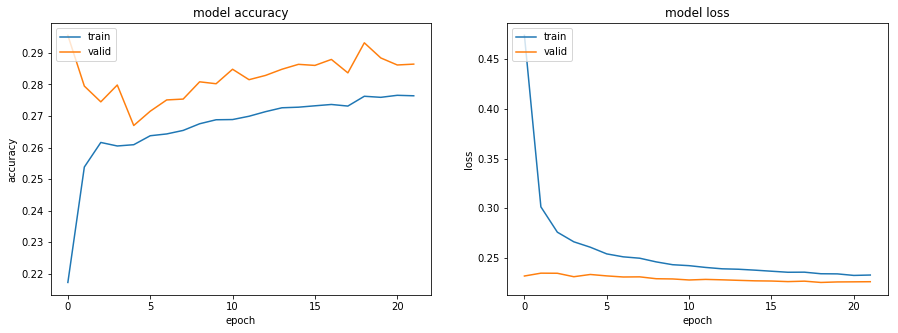

In [376]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [377]:
print("== Reload to best weights saved...")
model.load_weights(model_fn)

== Reload to best weights saved...


In [378]:
batch_size=64 #200
prediction=model.predict([x_query_train,x_doc_train,x_train],
          batch_size=batch_size,
         )

In [379]:
np.max(prediction)

0.93047988

In [380]:
np.min(prediction)

-0.13600512

In [381]:
np.max(y_train)

1.0

In [382]:
np.min(y_train)

-1.0

In [383]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_train, prediction)**0.5
print(RMSE)

0.473381911478


In [384]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
prediction_ori_scale = prediction+2
gold_ori_scale = y_train+2
RMSE = mean_squared_error(gold_ori_scale, prediction_ori_scale)**0.5
print(RMSE)

0.473381911329


In [385]:
np.min(gold_ori_scale)

1.0

# Predict

In [386]:
batch_size=64 #200
test_prediction=model.predict([x_query_test,x_doc_test,x_test],
          batch_size=batch_size,
         )

In [387]:
RMSE = mean_squared_error(y_test, test_prediction)**0.5
print(RMSE)

0.476397348934


In [388]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
test_prediction_ori_scale = test_prediction+2
test_gold_ori_scale = y_test+2
RMSE = mean_squared_error(test_gold_ori_scale, test_prediction_ori_scale)**0.5
print(RMSE)

0.476397348986


In [389]:
#0.4715 best with conv1d
#0.4739 best with full spec dense only 2x 64 hdim, 0.1 dropuot
#0.4730 best with full spec dense only 3x 64 hdim, 0.1 dropuot
#0.4725 best with full spec dense only 1x128 , 3x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x128 , 2x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot
#0.4741 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot

In [390]:
#vector alone
# 0.5232 0.2 dropout
# 0.5214 0.1 dropout